# Introduction

This tutorial is developed in order to provide to the reader free tools for implementing a simulation of Radiofrequency Ablation (RFA) on the atrial wall similar to that presented in [Irastorza et al. (2018)](https://doi.org/10.1111/jce.13363). It is based on the next packages and softwares:

- The tutorial is mostly written in [Python](https://www.python.org/) programming language.

- [SciPy](https://www.scipy.org/) is a Python-based ecosystem of open-source software for mathematics, science, and engineering. Some of the core packages are: [NumPy](http://www.numpy.org/), [library Scipy](https://www.scipy.org/scipylib/index.html), and [Matplotlib](https://matplotlib.org/).

- The mesh is generated with [Gmsh](http://gmsh.info/). Gmsh is copyright (C) 1997-2020 by C. Geuzaine and J.-F. Remacle and is distributed under the terms of the GNU General Public License (GPL).

- [FEniCS](https://fenicsproject.org/) which is a popular open-source ([LGPLv3](https://www.gnu.org/licenses/lgpl-3.0.en.html)) computing platform for solving partial differential equations (PDEs).
- For data analysis and visualization we use [ParaView](https://www.paraview.org/) uses a permissive BSD license.
- Particularly, the implementation of the RFA simulation is based on the code of Sheldon Hall under GNU General Public License v3.0 available in this [link](https://github.com/sheldonkhall/MITA-model).

We divide the tutorial in three steps: 1) Mesh generation, 2) Solving the RFA problem using Finite Element Method (FEM), and 3) Runing a simulation. The Mesh generation file is __*rfa-atrial-wall.geo*__. The file for solving the RFA problem is __*RFA_script.py*__.

# 1 Mesh generation

## 1.1 Geometry

The geometry is built with the CAD kernel provided by Gmsh (SetFactory("Built-in")). Gmsh has a graphical interface, can be scripted, and has a Python wrapper aswell. We prefer here, to write a script to parameterize the problem (the script should be ended with the extension __*.geo*__, particularly we named it __*rfa-atrial-wall.geo*__). The geometry is shown in the next figure:

![figure1.png](attachment:figure1.png "Geometry")

Note that the surface and lines labels toghether with the name of the geometric parameters are shown (with the same name as used in the script to facilitate the reading). 

## 1.2 Gmsh script

In general, a script of Gmsh has this [structure](https://gitlab.onelab.info/gmsh/gmsh/-/blob/master/tutorial/t1.geo), it begins with the definition of parameters.
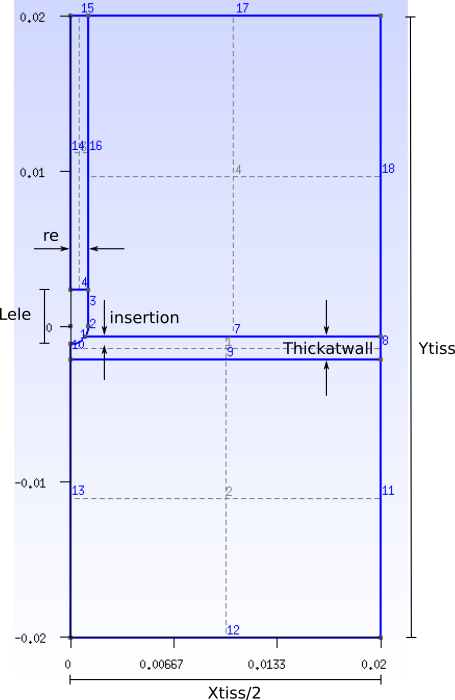

In [ ]:
elem = 0.0005; // electrode mesh 
tissm = 0.001; // tissue mesh 
Ytiss = 0.04; // height of tissue domain 
Xtiss = 0.04; // width of tissue domain 
re = 1.15e-3; // electrode radius (7Fr) 
Lele = 3.5e-3; // length of the electrode 
insertion = 0.5e-3;// insertion of the electrode within the tissue 
Thickatwall = 1.5e-3;// thickness of atrial wall

A comment in Gmsh starts with the //. The constants *elem* and *tissm* define the size of the mesh near to the active electrode and deeper in the tissue. The geometry is built by adding elementary entities as points, lines (between two points), and surfaces (delimited by lines that can also be curves).

In [ ]:
//Definitions of active electrode (metal) points
Point(1) = {0, 0, 0, elem};
Point(2) = {0, -re, 0, elem};
Point(3) = {Sqrt(re^2-(-re+insertion)^2), -re+insertion, 0, elem};
Point(4) = {re, 0, 0, elem};
Point(5) = {re, Lele-re, 0, elem};
Point(6) = {0, Lele-re, 0, elem};

//Definitions of tissues points
Point(7) = {0,Ytiss/2,0,tissm};
Point(8) = {Xtiss/2,Ytiss/2,0,tissm};
Point(9) = {Xtiss/2,-Ytiss/2,0,tissm};
Point(10) = {0,-Ytiss/2,0,tissm};

//Definitions of atrial wall points
Point(11) = {Xtiss/2,-re+insertion,0,elem};
Point(12) = {Xtiss/2,-re-(Thickatwall-insertion),0,elem};
Point(13) = {0,-re-(Thickatwall-insertion),0,elem};

//Definitions of electrode (plastic) points
Point(14) = {re, Ytiss/2, 0, tissm};

//Lines
Circle(1) = {2, 1, 3};
Circle(2) = {3, 1, 4};
Line(3) = {4, 5};
Line(4) = {5, 6};
Line(5) = {6, 1};
Line(6) = {1, 2};
Line(7) = {3, 11};
Line(8) = {11, 12};
Line(9) = {12, 13};
Line(10) = {13, 2};
Line(11) = {12, 9};
Line(12) = {9, 10};
Line(13) = {10, 13};
Line(14) = {6, 7};
Line(15) = {7, 14};
Line(16) = {14, 5};
Line(17) = {14, 8};
Line(18) = {8, 11};

A Point is defined by a list of four numbers: three coordinates (X, Y and Z), and a characteristic length (for example, we set the characteristic length of the active electrode to "elem" by the command *Point(1) = {0, 0, 0, elem};*). A line joins two points, for example line 3 joins points 4 and 5 by the command *Line(3) = {4, 5};*. To define a surface, we must define previously a *Line Loop* which delimites that.

In [ ]:
//Atrial wall
Line Loop(1) = {9, 10, 1, 7, 8};
Plane Surface(1) = {1};
//Connective tissue
Line Loop(2) = {13, -9, 11, 12};
Plane Surface(2) = {2};
//Plastic of the electrode
Line Loop(3) = {16, 4, 14, 15};
Plane Surface(3) = {3};
//Blood
Line Loop(4) = {7, -18, -17, 16, -3, -2};
Plane Surface(4) = {4};

Once points, lines and surfaces are defined, we must define the *Physical groups* which can be points, lines, and surfaces (in two dimensional problems). 

In [ ]:
Physical Surface(1) = {1}; // Atrial wall
Physical Surface(2) = {2}; // Connective tissue
Physical Surface(3) = {3}; // Plastic
Physical Surface(4) = {4}; // Blood

Physical Line(1) = {10,13,14}; // line of cylindrical symmetry
Physical Line(2) = {1,2,4}; // active electrode (metal)
Physical Line(3) = {11,12}; // passive electrode, U = 0 V and 37 deg
Physical Line(4) = {8,17,18}; // I = 0 A and 37 deg
Physical Line(5) = {3}; // perfusion constant temperature 40 deg
Physical Line(6) = {16}; // convective heat loss (plastic)
Physical Line(7) = {7}; // convective heat loss (tissue)

The tags defined for each group will be then stored in the generated mesh file (with extension __*.msh*__) and later read by FEniCS.

## 1.3 Mesh generation

The mesh is generated by typing in the command line *gmsh* followed by -2 (which indicates that is a 2D mesh) and the name of the file.

In [ ]:
%%bash
gmsh -2 rfa-atrial-wall.geo

It is generated a file called by default *rfa-atrial-wall.msh* that contains the mesh. The mesh can be visualized by typing *gmsh rfa-atrial-wall.msh* in the command line. Here, we show the graphical interface of Gmsh.

![figure2.png](attachment:figure2.png "Mesh")

The size of the mesh can be changed by modifying *elem* and *tissm*. Once the mesh is generated it can be used in other softwares of Finite Element Methods. The FEniCS software can read mesh with extension __*.xml*__ then the __*.msh*__ file converted using the *dolfin-convert* tool, which can be obtained from this [link](https://people.sc.fsu.edu/~jburkardt/py_src/dolfin-convert/dolfin-convert.html).
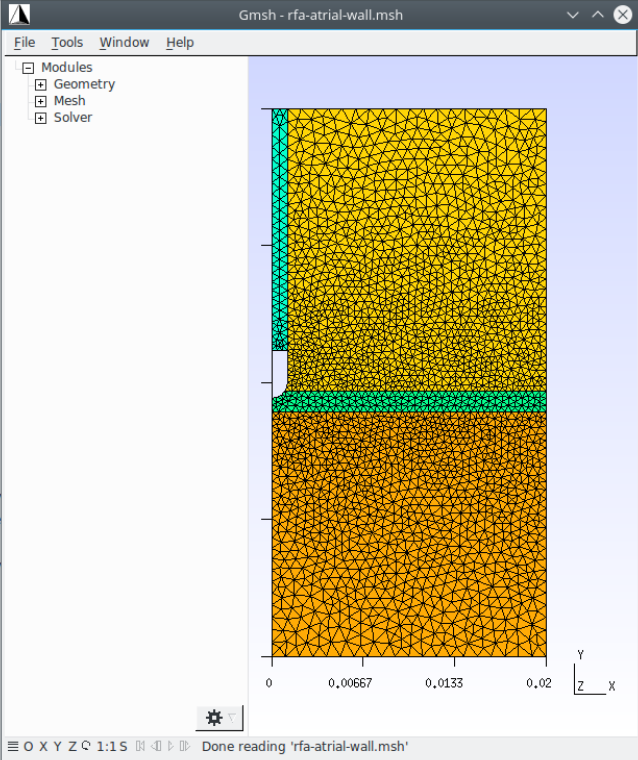

In [ ]:
%%bash
dolfin-convert rfa-atrial-wall.msh rfa-atrial-wall.xml

The convertion program generates three files: *rfa-atrial-wall.xml*, *rfa-atrial-wall_physical_region.xml*, and *rfa-atrial-wall_facet_region.xml*. These files contains information about the mesh, the domains, and the boundaries, respectively.
Next, we show part of the code that is in the file for solving the problem using FEM: __*RFA_script.py*__. The way that FEniCS reads the mesh information is by using an object *Mesh*.

In [ ]:
filename = "rfa-atrial-wall"
# Load geometry
mesh = Mesh(filename+".xml")

The boundary conditions and subdomains tagged as Physical Lines and Surfaces can be read by FEniCS using function of the mesh called *MeshFunction*:

In [ ]:
boundaries = MeshFunction("size_t", mesh, filename+"_facet_region.xml")
subdomains = MeshFunction("size_t", mesh, filename+"_physical_region.xml")

With these three sentences we have all the geometric information to numerically solve the RFA problem. See the next step [2) Solving the RFA problem using Finite Element Method (FEM)](https://github.com/rirastorza/RFA-tutorial/blob/master/solving%20by%20fem/solvingbyfem.ipynb).